In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, chi2
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load cleaned data
train_data = pd.read_csv('../data/cleaned_dataset/cleaned_standardized_train_data.csv')
test_data = pd.read_csv('../data/cleaned_dataset/cleaned_standardized_test_data.csv')

In [4]:
# Split loaded data into data and target
X_train = train_data[train_data.columns[:-1]]
y_train = train_data['goal']

X_test = test_data[test_data.columns[:-1]]
y_test = test_data['goal']

In [5]:
# Convert train and test data to array
X_train_scaled = X_train.to_numpy()
X_test_scaled = X_test.to_numpy()

### Use Feature Importance (Random Forest / XGBoost feature importance scores) to rank variables.

In [7]:
# Apply model on training data
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

# Get feature importance (using only training features)
feature_importance = rf.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)
importance_df.head(14)

,Feature,Importance
18,ca_0.0,0.120893
5,thalach,0.093793
7,oldpeak,0.092372
3,chol,0.088257
0,age,0.079385
11,cp_4.0,0.078689
24,thal_7.0,0.074801
2,trestbps,0.072693
22,thal_3.0,0.056854
6,exang,0.036564


### Apply Recursive Feature Elimination (RFE) to select the best predictors.

In [8]:
# Initialize model
estimator = RandomForestClassifier(n_estimators=100, random_state=42)

# Apply RFE to select top 14 features
rfe = RFE(estimator=estimator, n_features_to_select=14)
rfe.fit(X_train_scaled, y_train)

# Mask of selected features
selected_mask = rfe.support_

# Get feature names
selected_features = X_train.columns[selected_mask]
print("Selected Features:", list(selected_features))

Selected Features: ['age', 'sex', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak', 'cp_3.0', 'cp_4.0', 'slope_1.0', 'slope_2.0', 'ca_0.0', 'thal_3.0', 'thal_7.0']


In [9]:
# Save Reduced dataset
pd.concat([train_data[selected_features], y_train], axis=1).to_csv('../data/reduced_dataset/reduced_train_data.csv', index=False)
pd.concat([test_data[selected_features], y_test], axis=1).to_csv('../data/reduced_dataset/reduced_test_data.csv', index=False)

### Chi-Square Test to check feature significance.

In [10]:
chi2_scores, p_values = chi2(X_train[selected_features], y_train)

# Combine results
chi2_results = pd.DataFrame({
    'Feature': selected_features,
    'Chi2 Score': chi2_scores,
    'p-value': p_values
}).sort_values(by='Chi2 Score', ascending=False)

print(chi2_results)

      Feature  Chi2 Score       p-value
13   thal_7.0   30.956508  2.638757e-08
8      cp_4.0   27.275747  1.764103e-07
5       exang   26.504566  2.629160e-07
11     ca_0.0   26.431930  2.729903e-07
12   thal_3.0   26.391664  2.787408e-07
7      cp_3.0   17.179577  3.400728e-05
9   slope_1.0   15.010856  1.068945e-04
10  slope_2.0   13.571285  2.296721e-04
6     oldpeak    8.998320  2.702279e-03
1         sex    5.326931  2.099832e-02
4     thalach    2.010327  1.562317e-01
0         age    0.739668  3.897672e-01
2    trestbps    0.581575  4.456955e-01
3        chol    0.161675  6.876193e-01


### Feature importance ranking visualization

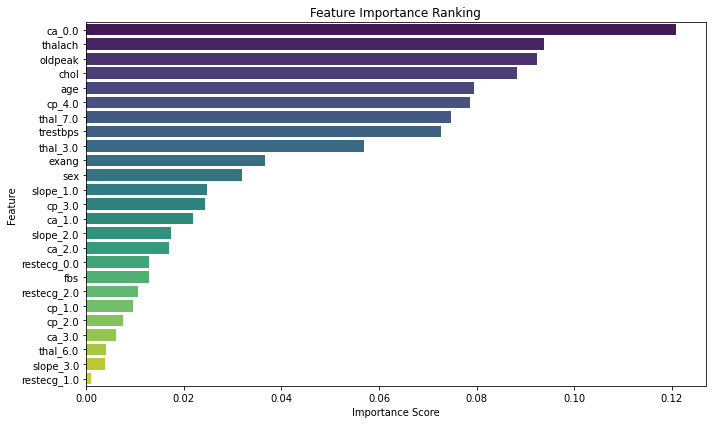

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance Ranking')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()